In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mat73
from smoothen_surface import smoothen

%matplotlib notebook

In [39]:
# Read data
data = mat73.loadmat("SKULL-MAPS/skull_mask_bm7_dx_1.25mm.mat")

xi = data["xi"]
yi = data["yi"]
zi = data["zi"]

skull_mask = data["skull_mask"]
brain_mask = data["brain_mask"]

In [40]:
# Get skull points
X, Y, Z = np.meshgrid(xi, yi, zi, indexing="ij")

x_skull = X[skull_mask]
y_skull = Y[skull_mask]
z_skull = Z[skull_mask]

In [41]:
# Create a dataframe
p_skull_volume = np.hstack((x_skull[:, np.newaxis],
                            y_skull[:, np.newaxis],
                            z_skull[:, np.newaxis]))
skull_volume_df = pd.DataFrame(p_skull_volume, columns=["X", "Y", "Z"])

In [42]:
# Get minimum and maximum at each (Y, Z) points
skull_surface_inner_df = skull_volume_df.groupby(["Y", "Z"]).max().reset_index()
skull_surface_outer_df = skull_volume_df.groupby(["Y", "Z"]).min().reset_index()

# Rearrange columns
skull_surface_inner_df = skull_surface_inner_df[["X", "Y", "Z"]]
skull_surface_outer_df = skull_surface_outer_df[["X", "Y", "Z"]]

# Sort based on Y and Z columns
skull_surface_inner_df = skull_surface_inner_df.sort_values(by=["Y", "Z"])
skull_surface_outer_df = skull_surface_outer_df.sort_values(by=["Y", "Z"])

In [43]:
# Convert to numpy array
skull_surface_inner = skull_surface_inner_df.to_numpy()
skull_surface_outer = skull_surface_outer_df.to_numpy()

In [47]:
X = skull_surface_inner[:, 0].reshape(yi.shape[0], zi.shape[0])
Y = skull_surface_outer[:, 1].reshape(yi.shape[0], zi.shape[0])
Z = skull_surface_outer[:, 2].reshape(yi.shape[0], zi.shape[0])

<IPython.core.display.Javascript object>


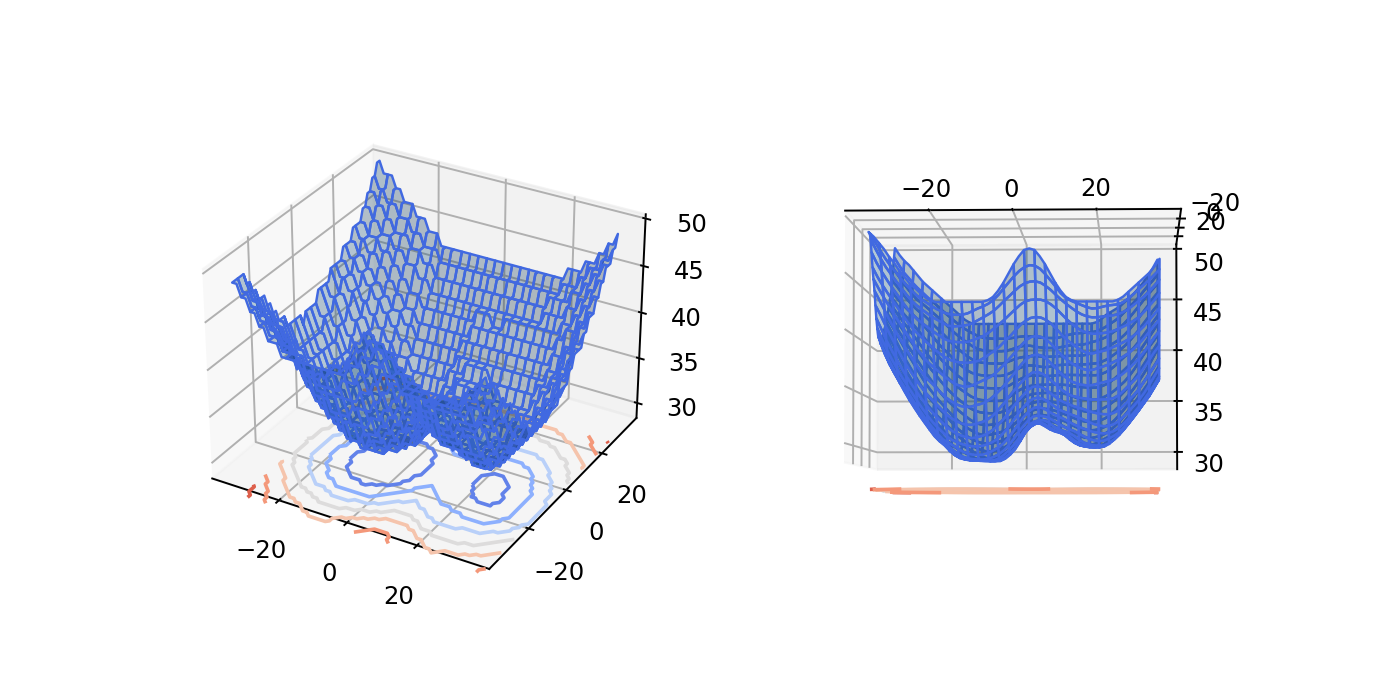

In [49]:
# Before smoothing
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121, projection="3d")

ax1.plot_surface(Y, Z, X, edgecolor='royalblue', alpha=0.3)
ax1.contour(Y, Z, X, zdir='z', offset=26, cmap='coolwarm')

# After smoothing
X_smooth = smoothen(X, 2)

ax2 = fig.add_subplot(122, projection="3d")

ax2.plot_surface(Y, Z, X_smooth, edgecolor='royalblue', alpha=0.3)
ax2.contour(Y, Z, X_smooth, zdir='z', offset=26, cmap='coolwarm')